<a id='title'></a>
# **Covid19 Vaccination Centers in Lima, Peru**
### Coursera Data Science Capstone - *The battle of neighborhoods (week 2)*
---

### **Content**
- [1. Introduction / Business Understanding](#introduction)
    - [1.1 Background](#introduction)
    - [1.2 The problem](#problem_statement)
    - [1.3 Intended audience](#audience)
    - [1.4 Geographic scope](#geoscope)
- [2. Data Requirements](#data_req)
    - [2.1 Description of the data](#data_req)
    - [2.2 How the data will be used](#data_use)
- [3. Data Adquisition and Preparation](#data_prep)
    - [3.1 Creating a dataframe with district data](#dfdistricts)
    - [3.2 Creating a dataframe with vaccination centers data](#dfcenters)
    - [3.3 Creating a dataframe with venues data using Foursquare](#dfvenues)
- [4. Methodology](#methodology)
    - [4.1 Algorithm and hyperparameters](#algorithm)
    - [4.2 Taking a look into the data](#taking_look)
    - [4.3 The definitive dataframe](#def_df)
    - [4.4 Epsilon hyperparameter with KNN](#epsilon)
    - [4.5 First run of DBSCAN algorithm](#dbscan1)
    - [4.6 A problem with first DBSCAN run](#problem)
    - [4.7 Second run of DBSCAN algorithm](#dbscan2)
- [5. Results](#results)
    - [5.1 Clusters with vaccination centers](#result1)
    - [5.2 Clusters without vaccination centers](#result2)
- [6. Discussion](#discussion)
- [7. Conclusion](#conclusion)

---
<a id='introduction'></a>
### **1. Introduction**
#### **1.1 Background**
The covid-19 pandemic has negatively impacted the health, economy, education and other aspects of our society since the beginning of 2020. Peru has been one of the countries with the most infections and deaths per million inhabitants in the world, reaching almost 200k deaths since the start of the pandemic.
Below are the accumulated indicators related to the impact of the disease throughout the country according to the Ministry of Health as of August 29, 2021.

| Measure | Result |
|---|---|
| Tests performed | 16 733 426 |
| Positive cases | 2 149 591 |
| Deaths | 198 263 |

**Source:** https://www.gob.pe/institucion/minsa/noticias/514015-minsa-casos-confirmados-por-coronavirus-covid-19-ascienden-a-2-149-591-en-el-peru-comunicado-n-662

<a id='problem_statement'></a>
#### **1.2 The problem**
The Ministry of Health has installed many vaccination centers in most districts of the country, and since February 9th 2021, the national vaccination strategy has been carried out, scheduling appointments for each inhabitant of the country by age groups, starting with the elderly and decreasing the age range over the weeks.

Recently, other risk groups are being included in the vaccination schedule (rare and orphan diseases and neurodevelopmental disorders) without age restriction (they must only be 12 years or older) in addition to the possibility of being vaccinated in a district other than their residence. This is causing alterations in the flow of people traveling to vaccination centers, resulting in two possible scenarios:
- Long queues outside the vaccination centers
- Empty vaccination centers

This project's objective is to suggest the number and location of vaccination centers based on the density of population in Lima. This can be used to redirect staff from vaccination centers to appropriate locations to avoid wasting health professional resources.

<a id='audience'></a>
#### **1.3 Intended audience**
Directors and management staff of:
- Ministry of Health
- EsSalud (social insurance)
- District municipalities
- Private health centers

<a id='geoscope'></a>
#### **1.4 Geographic scope**
This project will cover the districts from Lima and Callao provinces.

- Image on the left: Lima location within the country
- Image on the right: Districts of Lima and Callao

<img src="img scope/Peru_Lima_Lima.png" width="325" /> <img src="img scope/Lima-Callao.png" width="248" />

---
<a id='data_req'></a>
### **2. Data Requirements**
The data to be used in this project comes from two principal sources:
- Open Data National Platform https://www.datosabiertos.gob.pe/
- Foursquare

#### **2.1 Description of the data**
The following data will be required for this project:
- List of *ubigeo* equivalences (codes assigned to each district in Peru) available in the Open Data National Platform
- List of venues of Lima (extracted with Foursquare, from all districts in Lima)
- List of vaccination centers with location data (longitude/latitude) available in the Open Data National Platform


#### **2.2 How the data will be used**

**List of *ubigeo* equivalences:** First it will be filtered with the location data from districts of Lima, these coordinates will be used to search venues with Foursquare.
This dataset will also be merged with the list of vaccination centers. It has the codes given to each district, which are the data to filter the vaccination centers in this project's scope. This dataset has 17 columns from which the following are of interest for this project:

| Column | Type | Description |
|---|---|---|
| ID Ubigeo | Number | Code assigned to districts |
| Department | Text | 1st level of local government, most of times called regional |
| Province | Text | 2nd level of local government |
| District | Text | 3rd level of local government |
| Region | Text | Administrative division, in most cases the same that Department |
| Surface | Number | District area in square kilometers |
| Latitude | Number | Location data |
| Longitude | Number | Location data |

Link: https://www.datosabiertos.gob.pe/dataset/codigos-equivalentes-de-ubigeo-del-peru

**List of vaccination centers:** This is a list of places where the vaccination process is being taken. The purpose to use this data is to plot the locations to analyze if the vaccination centers are near to a point of high population density. Some of the columns that will be used from this dataset are:

| Column | Type | Description |
|---|---|---|
| ID Ubigeo | Number | District code where the vaccination center has been installed |
| Vaccination Center | Text | Name of the place that hosts the vaccination center |
| Latitude | Number | Location data |
| Longitude | Number | Location data |

Link: https://www.datosabiertos.gob.pe/dataset/centros-de-vacunacion

**List of venues of Lima:** It will be extracted with Foursquare to determine the concentration of dwellings by clustering the venues. For this project, due to the nearness between Lima and Callao, the districts in this two provinces will be included. This dataset will have the following columns:

| Column | Type |
|---|---|
| Venue Name | Text |
| Category | Text |
| Longitude | Number |
| Latitude | Number |

It will be deduced that each cluster of venues or dwellings is a point of high population density.

---
<a id='data_prep'></a>
### **3. Data Acquisition and Preparation**
This section is divided in the following steps:

- [3.1 Creating a dataframe with district data](#dfdistricts)
- [3.2 Creating a dataframe with vaccination centers data](#dfcenters)
- [3.3 Creating a dataframe with venues data using Foursquare](#dfvenues)

First we will download the list of ubigeos and vaccination centers from https://www.datosabiertos.gob.pe/ and save them in `data orig` folder.
- https://www.datosabiertos.gob.pe/dataset/codigos-equivalentes-de-ubigeo-del-peru
- https://www.datosabiertos.gob.pe/dataset/centros-de-vacunacion

Then, import the necessary libraries.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import requests
import folium

<a id='dfdistricts'></a>
#### **3.1 Creating a dataframe with district data**
Considerations:
- Lima and Callao provinces are *LIMA PROVINCIA* and *CALLAO* values in **region** column.
- A new column **num_requests** will be created comparing the district surface to an area in a 3Km radius circle (~ 28.27 Km<sup>2</sup>).
- Column num_requests will tell the number of times we will query to Foursquare for venues near to a 3Km radius area. If the division between district surface and 28.27 Km<sup>2</sup> is more than 1, then num_requests will be equal to 2, that means all the venues in the result of the first query will be used as central coordinates for new requests.

In [2]:
# Read dataset TBL_UBIGEOS.csv
dfdis = pd.read_csv("data orig/TB_UBIGEOS.csv")
# Filter by regions Lima and Callao
dfdis = dfdis[dfdis.region.isin(["LIMA PROVINCIA","CALLAO"])]
# Delete not necessary columns
dfdis.drop(["ubigeo_reniec","ubigeo_inei","departamento_inei","provincia_inei","macroregion_inei",
         "macroregion_minsa","iso_3166_2","fips","altitud"], axis=1, inplace=True)
dfdis.rename(columns={"departamento":"department","provincia":"province","distrito":"district",
                   "superficie":"surface","latitud":"latitude","longitud":"longitude"}, inplace=True)
# Drop rows if laitude is NaN
dfdis.dropna(subset=["latitude"], axis=0, inplace=True)
# Calculate new column Number of Requests (times we will query Foursquare based on the surface divided by a 3Km radius circle area)
dfdis["num_requests"] = np.ceil(dfdis["surface"]/(9*np.pi)) # Area in 3 Km radius = pi * radius^2 = 28.27 Km^2
dfdis["num_requests"] = dfdis["num_requests"].astype("int") # Change data type
dfdis["num_requests"] = [2 if x>1 else 1 for x in dfdis["num_requests"]] # Two times maximum for running requests to Foursquare
# Reset index
dfdis.reset_index(drop=True, inplace=True)
dfdis

id_ubigeo department province                    district          region  \
0         690     CALLAO   CALLAO                      CALLAO          CALLAO   
1         691     CALLAO   CALLAO                  BELLAVISTA          CALLAO   
2         692     CALLAO   CALLAO  CARMEN DE LA LEGUA REYNOSO          CALLAO   
3         693     CALLAO   CALLAO                    LA PERLA          CALLAO   
4         694     CALLAO   CALLAO                    LA PUNTA          CALLAO   
5         695     CALLAO   CALLAO                  VENTANILLA          CALLAO   
6         696     CALLAO   CALLAO                     MI PERU          CALLAO   
7        1281       LIMA     LIMA                        LIMA  LIMA PROVINCIA   
8        1282       LIMA     LIMA                       ANCON  LIMA PROVINCIA   
9        1283       LIMA     LIMA                         ATE  LIMA PROVINCIA   
10       1284       LIMA     LIMA                    BARRANCO  LIMA PROVINCIA   
11       1285       LIMA     LIMA                       BREÑA  LIMA PROVINCIA   
12       1286       LIMA     LIMA                  CARABAYLLO  LIMA PROVINCIA   
13       1287       LIMA     LIMA                  CHACLACAYO  LIMA PROVINCIA   
14       1288       LIMA     LIMA                  CHORRILLOS  LIMA PROVINCIA   
15       1289       LIMA     LIMA                 CIENEGUILLA  LIMA PROVINCIA   
16       1290       LIMA     LIMA                       COMAS  LIMA PROVINCIA   
17       1291       LIMA     LIMA                 EL AGUSTINO  LIMA PROVINCIA   
18       1292       LIMA     LIMA               INDEPENDENCIA  LIMA PROVINCIA   
19       1293       LIMA     LIMA                 JESUS MARIA  LIMA PROVINCIA   
20       1294       LIMA     LIMA                   LA MOLINA  LIMA PROVINCIA   
21       1295       LIMA     LIMA                 LA VICTORIA  LIMA PROVINCIA   
22       1296       LIMA     LIMA                       LINCE  LIMA PROVINCIA   
23       1297       LIMA     LIMA                  LOS OLIVOS  LIMA PROVINCIA   
24       1298       LIMA     LIMA                  LURIGANCHO  LIMA PROVINCIA   
25       1299       LIMA     LIMA                       LURIN  LIMA PROVINCIA   
26       1300       LIMA     LIMA           MAGDALENA DEL MAR  LIMA PROVINCIA   
27       1301       LIMA     LIMA                PUEBLO LIBRE  LIMA PROVINCIA   
28       1302       LIMA     LIMA                  MIRAFLORES  LIMA PROVINCIA   
29       1303       LIMA     LIMA                  PACHACAMAC  LIMA PROVINCIA   
30       1304       LIMA     LIMA                    PUCUSANA  LIMA PROVINCIA   
31       1305       LIMA     LIMA               PUENTE PIEDRA  LIMA PROVINCIA   
32       1306       LIMA     LIMA               PUNTA HERMOSA  LIMA PROVINCIA   
33       1307       LIMA     LIMA                 PUNTA NEGRA  LIMA PROVINCIA   
34       1308       LIMA     LIMA                       RIMAC  LIMA PROVINCIA   
35       1309       LIMA     LIMA                 SAN BARTOLO  LIMA PROVINCIA   
36       1310       LIMA     LIMA                   SAN BORJA  LIMA PROVINCIA   
37       1311       LIMA     LIMA                  SAN ISIDRO  LIMA PROVINCIA   
38       1312       LIMA     LIMA      SAN JUAN DE LURIGANCHO  LIMA PROVINCIA   
39       1313       LIMA     LIMA      SAN JUAN DE MIRAFLORES  LIMA PROVINCIA   
40       1314       LIMA     LIMA                    SAN LUIS  LIMA PROVINCIA   
41       1315       LIMA     LIMA        SAN MARTIN DE PORRES  LIMA PROVINCIA   
42       1316       LIMA     LIMA                  SAN MIGUEL  LIMA PROVINCIA   
43       1317       LIMA     LIMA                 SANTA ANITA  LIMA PROVINCIA   
44       1318       LIMA     LIMA         SANTA MARIA DEL MAR  LIMA PROVINCIA   
45       1319       LIMA     LIMA                  SANTA ROSA  LIMA PROVINCIA   
46       1320       LIMA     LIMA           SANTIAGO DE SURCO  LIMA PROVINCIA   
47       1321       LIMA     LIMA                   SURQUILLO  LIMA PROVINCIA   
48       1322       LIMA     LIMA  

In [3]:
# Checking column data types
dfdis.dtypes

id_ubigeo         int64
department       object
province         object
district         object
region           object
surface         float64
latitude        float64
longitude       float64
num_requests      int64
dtype: object

<a id='dfcenters'></a>
#### **3.2 Creating a dataframe with vaccination centers data**
Considerations:
- The dataset with vaccination centers will be merged with the district dataframe to get only the vaccination centers in Lima and Callao provinces.

In [4]:
# Read dataset TB_CENTRO_VACUNACION.csv and merge (inner join) with district dataframe (dfdis)
dfvac = pd.merge(pd.read_csv("data orig/TB_CENTRO_VACUNACION.csv"), dfdis, on='id_ubigeo', how='inner')
# Delete not necessary columns
dfvac.drop(["id_centro_vacunacion","entidad_administra","surface","latitude","longitude",
         "num_requests"], axis=1, inplace=True)
dfvac.rename(columns={"nombre":"vaccination_center","latitud":"latitude","longitud":"longitude"}, inplace=True)
pd.set_option('display.max_rows', None)
dfvac

id_ubigeo                                 vaccination_center   latitude  \
0         1317                    Vacunatorio San Isidro labrador -12.043744   
1         1317                   Estadio Municipal de Santa Anita -12.034220   
2         1292                            Clínica Jesus Del Norte -11.989580   
3         1292                                        Plaza Norte -12.007614   
4         1292                 Coliseo de la Amistad Perú - Japón -11.978520   
5         1281                       Centro De Vacunación Aljovin -12.057287   
6         1281   Universidad Nacional Mayor de San Marcos - UNMSM -12.056170   
7         1281                              Clínica Internacional -12.058217   
8         1281                               Parque La Exposición -12.062962   
9         1281                                Visita Domiciliaria -12.049450   
10        1281                              Punto de Vacunación 1 -12.059328   
11        1311   Complejo Deportivo - Municipalidad De San Isidro -12.108021   
12        1311                              Clínica Ricardo Palma -12.090467   
13        1311                             Clínica Angloamericana -12.109345   
14        1311                                     Clinica Aliada -12.092212   
15        1312                  Clínica San Miguel Arcangel (Sjl) -11.970352   
16        1312            Estadio Monumental Anexo 22 San Antonio -11.921603   
17        1312                              I.E Niños Del Paraiso -12.002772   
18        1312                                I.E. Antenor Orrego -11.878979   
19        1312        Clínica San Juan Bautista - Grupo San Pablo -12.008310   
20        1312                            Parque Zonal Huiracocha -12.008310   
21        1312               Universidad César Vallejo - Sede Sjl -11.981377   
22        1312                             IPD COMPLEJO DEPORTIVO -11.956181   
23        1312             ESTADIO MUNICIPAL ANEXO 22 SAN ANTONIO -11.919156   
24        1312                                I.E. ANTENOR ORREGO -11.878979   
25        1312                              I.E NIÑOS DEL PARAISO -12.002772   
26        1312                                           INPE SJL -11.992415   
27        1312                                  IE. SANTO DOMINGO -11.900260   
28        1313                                   Complejo Del Ipd -12.162643   
29        1313                         Módulo Deportivo Siglo Xxi -12.163024   
30        1315                           Parque Zonal Mayta Capac -12.009103   
31        1315                    Gran Unidad Escolar Jose Granda -12.026996   
32        1315  Instituto Nacional de Salud Mental "Honorio De... -12.020600   
33        1320                      I.E.F.A.P Manuel Polo Jiménez -12.148859   
34        1320                              Base Aérea Las Palmas -12.157931   
35        1320                                  Clínica San Pablo -12.100092   
36        1320                       Campo Deportivo Las Malvinas -12.142089   
37        1320                               Jockey Club del Perú -12.097407   
38        1320                                Monte de Los Olivos -12.138890   
39        1298  Explanada De Vacunacion  Del Establecimiento D... -12.007212   
40        1298                       Loza Deportiva Valle Triunfo -11.985359   
41        1298                       Estadio Municipal de Chosica -11.941486   
42        1298   Ie Manuel Fernando Cabrel Nicho  - Cajamarquilla -11.986643   
43        1298   EXPLANADA DE VACUNACIÓN  DEL ESTABLECIMIENTO ... -12.007212   
44        1298                       LOZA DEPORTIVA VALLE TRIUNFO -11.985359   
45        1290                           Parque Zonal Sinchi Roca -17.651580   
46        1290             Explanada de la Municipalidad de Comas -11.948411   
47        1290                             Plaza Cívica Año Nuevo -11.923830   
48        1290                                Colegio La Libertad -11.920800   
49   

In [5]:
pd.reset_option('max_rows')
# Checking column data types
dfvac.dtypes

id_ubigeo               int64
vaccination_center     object
latitude              float64
longitude             float64
department             object
province               object
district               object
region                 object
dtype: object

<a id='dfvenues'></a>
#### **3.3 Creating a dataframe with venues data**
Considerations:
- To get this dataset we will use Foursquare
- Each request will have 100 venues as limit and 3 Km as radius
- The district coordinates (lat/long) will be used as central points for each request
- If the district has `num_requests = 2` then all the venues in the result of the query to Foursquare will be used as central points for a second query. This is to cover a greater surface that posibly has more population density

#### **Setup:** 
First we will setup the parameters to use in each request to Foursquare

In [6]:
# Setup Foursquare credentials and limits
CLIENT_ID = 'MSCXPOVAYO4TGJNPQ0ZYQ1DFIYIW1AHDBQ4G25RRXADSP304' # Foursquare ID
CLIENT_SECRET = 'VOHBJF1JHQAHJET21WF3YHNE4IMX2IZFRXIEKJADMMO3SLTY' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
limit = 100 # Limit of number of venues returned by Foursquare API
radius = 3000 # 3 Km of radius

#### **Functions:**
The following functions will be used to simplify the collection:
- **`get_category`** to get the category of each venue
- **`get_venues`** to request the venues through Foursquare


**Function `get_category`:**

In [7]:
# Function that extracts the category of venues
def get_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Function `get_venues`:**

In [8]:
# Function that returns a dataframe with venues
def get_venues(clientid, secret, vers, lat, lng, rad, lim):
    # Setup the URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        clientid, secret, vers, lat, lng, rad,lim)
    # Results
    results = requests.get(url).json()
    # Venues
    venues_json = results['response']['groups'][0]['items']
    venues = pd.json_normalize(venues_json) # flatten JSON
    # Filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]
    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category, axis=1)
    # Clean columns
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    return venues

#### **Queries to Foursquare:**

**First run:** Will use the data from districts dataframe as central points. The resultant dataframe will have the origin district from which the query was run.

In [9]:
# Create empty dataframe dfven
dfven = pd.DataFrame(columns = ["name","categories","lat","lng","origin_district","num_requests"])

# First search of venues with data from district list
for i in dfdis.itertuples():
    # Look up venues
    venues = get_venues(CLIENT_ID, CLIENT_SECRET, VERSION, i.latitude, i.longitude, radius, limit)
    venues["origin_district"] = i.district
    venues["num_requests"] = i.num_requests
    # Append dataframe
    dfven = dfven.append(venues)
# Clean the dataframe
dfven.drop_duplicates(subset=["name","categories","lat","lng"], inplace=True)
dfven.reset_index(drop=True, inplace=True)
dfven

name                  categories        lat  \
0                  CasaCor Callao                  Public Art -12.060004   
1                      Casa Fugaz                 Art Gallery -12.060145   
2       Fortaleza del Real Felipe         Monument / Landmark -12.062062   
3     Cabos Restaurante de Puerto          Seafood Restaurant -12.060282   
4                Panadería Olcese                      Bakery -12.061041   
...                           ...                         ...        ...   
1837   Cementerio Nueva Esperanza                    Cemetery -12.164202   
1838            Estación San Juan          Light Rail Station -12.156942   
1839           Ms 26 De Noviembre           Food & Drink Shop -12.168051   
1840                 Santa Alitas          Mexican Restaurant -12.172082   
1841      Constructora Lasage SAC  Construction & Landscaping -12.167570   

            lng          origin_district num_requests  
0    -77.147282                   CALLAO            2  
1    -77.147335                   CALLAO            2  
2    -77.148059                   CALLAO            2  
3    -77.150105                   CALLAO            2  
4    -77.143544                   CALLAO            2  
...         ...                      ...          ...  
1837 -76.919884  VILLA MARIA DEL TRIUNFO            2  
1838 -76.966931  VILLA MARIA DEL TRIUNFO            2  
1839 -76.919174  VILLA MARIA DEL TRIUNFO            2  
1840 -76.966780  VILLA MARIA DEL TRIUNFO            2  
1841 -76.916610  VILLA MARIA DEL TRIUNFO            2  

[1842 rows x 6 columns]

**Second run:** Will use the data from venues dataframe as central points. For this purpose a temporary dataframe *newsource* will be created, this will have the venues from districts with `num_requests > 1`

In [10]:
# Create new source from dataframe dfven
newsource = dfven.copy() #Copy the dataframe
newsource = newsource[newsource.num_requests > 1] # Filter rows by num_requests column
newsource["num_requests"] = newsource["num_requests"] - 1
newsource.drop_duplicates(subset=["name","categories","lat","lng"], inplace=True)
newsource.reset_index(drop=True, inplace=True)

# Create empty dataframe dfven2
dfven2 = pd.DataFrame(columns = ["name","categories","lat","lng","origin_district","num_requests"])

# Second search of venues with data from new source
for j in newsource.itertuples():
    # Look up venues
    venues = get_venues(CLIENT_ID, CLIENT_SECRET, VERSION, j.lat, j.lng, radius, limit)
    venues["origin_district"] = j.origin_district
    venues["num_requests"] = j.num_requests
    # Append dataframe
    dfven2 = dfven2.append(venues)

# Clean the dataframe
dfven2.drop_duplicates(subset=["name","categories","lat","lng"], inplace=True)
dfven2.reset_index(drop=True, inplace=True)
dfven2

name           categories  \
0                                CasaCor Callao           Public Art   
1                                    Casa Fugaz          Art Gallery   
2                   Cabos Restaurante de Puerto   Seafood Restaurant   
3                     Fortaleza del Real Felipe  Monument / Landmark   
4                             Monumental Callao          Art Gallery   
...                                         ...                  ...   
2158  Mercado "Señor de la Divina Misericordia"        Shopping Mall   
2159                          Urb. Los Parrales                 Park   
2160                      Parque Julio C. Tello                 Park   
2161                  El Hueco, barra cebichera   Seafood Restaurant   
2162                                  Ciclo via                Trail   

            lat        lng          origin_district num_requests  
0    -12.060004 -77.147282                   CALLAO            1  
1    -12.060145 -77.147335                   CALLAO            1  
2    -12.060282 -77.150105                   CALLAO            1  
3    -12.062062 -77.148059                   CALLAO            1  
4    -12.059839 -77.147090                   CALLAO            1  
...         ...        ...                      ...          ...  
2158 -12.152731 -76.991412  VILLA MARIA DEL TRIUNFO            1  
2159 -12.167568 -76.992087  VILLA MARIA DEL TRIUNFO            1  
2160 -12.148285 -76.991862  VILLA MARIA DEL TRIUNFO            1  
2161 -12.165424 -76.992030  VILLA MARIA DEL TRIUNFO            1  
2162 -12.195898 -76.957242  VILLA MARIA DEL TRIUNFO            1  

[2163 rows x 6 columns]

After the two runs, we will join both dataframes and drop duplicates.

In [11]:
dfven = dfven.append(dfven2)
dfven.drop_duplicates(subset=["name","categories","lat","lng"], inplace=True)
dfven.reset_index(drop=True, inplace=True)
dfven.rename(columns={"name":"venue_name","categories":"category"}, inplace=True)
dfven.drop(["num_requests"], axis=1, inplace=True)
dfven

venue_name             category  \
0                                CasaCor Callao           Public Art   
1                                    Casa Fugaz          Art Gallery   
2                     Fortaleza del Real Felipe  Monument / Landmark   
3                   Cabos Restaurante de Puerto   Seafood Restaurant   
4                              Panadería Olcese               Bakery   
...                                         ...                  ...   
2718  Mercado "Señor de la Divina Misericordia"        Shopping Mall   
2719                          Urb. Los Parrales                 Park   
2720                      Parque Julio C. Tello                 Park   
2721                  El Hueco, barra cebichera   Seafood Restaurant   
2722                                  Ciclo via                Trail   

            lat        lng          origin_district  
0    -12.060004 -77.147282                   CALLAO  
1    -12.060145 -77.147335                   CALLAO  
2    -12.062062 -77.148059                   CALLAO  
3    -12.060282 -77.150105                   CALLAO  
4    -12.061041 -77.143544                   CALLAO  
...         ...        ...                      ...  
2718 -12.152731 -76.991412  VILLA MARIA DEL TRIUNFO  
2719 -12.167568 -76.992087  VILLA MARIA DEL TRIUNFO  
2720 -12.148285 -76.991862  VILLA MARIA DEL TRIUNFO  
2721 -12.165424 -76.992030  VILLA MARIA DEL TRIUNFO  
2722 -12.195898 -76.957242  VILLA MARIA DEL TRIUNFO  

[2723 rows x 5 columns]

In [12]:
# Checking column data types
dfven.dtypes

venue_name          object
category            object
lat                float64
lng                float64
origin_district     object
dtype: object

#### **Data export:**

Finally we will export the dataframes as CSV files for further usage.

In [13]:
dfdis.to_csv("data clean/districts.csv", index=False)
dfvac.to_csv("data clean/vaccination centers.csv", index=False)
dfven.to_csv("data clean/venues.csv", index=False)

---
<a id='methodology'></a>
### **4. Methodology**
The section is divided in the following steps:
- [4.1 Algorithm and hyperparameters](#algorithm)
- [4.2 Taking a look into the data](#taking_look)
- [4.3 The definitive dataframe](#def_df)
- [4.4 Epsilon hyperparameter](#epsilon)
- [4.5 First run of DBSCAN algorithm](#dbscan1)
- [4.6 A problem with first DBSCAN run](#problem)
- [4.7 Second run of DBSCAN algorithm](#dbscan2)

<a id='algorithm'></a>
#### **4.1 Algorithm and hyperparameters**
Since we want to plot high density population clusters, the algorith to use is DBSCAN. To estimate the hyperparameters we will use the recommendations by Tara Mullin in https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd.

- **Minimum samples:** Dimensions multiplied by 2 (2 x 2 = 4). For the venues dataset, as this has almost 2000 rows, we're incrementing the minimum samples to 5.
- **Epsilon:** Average distance between each point and its k nearest neighbors, where k is equal to the minimum samples.

<a id='taking_look'></a>
#### **4.2 Taking a look into the data**
The follong code is to take a look to the data about venues and vaccination centers. To do this, we will plot both datasets *centers* and *venues*.
- Venues: Small blue circles
- Vaccination centers: Large yellow circles

In [14]:
# Read datasets exported in Data preparation section
districts = pd.read_csv("data clean/districts.csv")
centers = pd.read_csv("data clean/vaccination centers.csv")
venues = pd.read_csv("data clean/venues.csv")

In [15]:
# Plot a map starting in Lima center
map_lima = folium.Map(location = [-12.0453,-77.0308], zoom_start = 11)

# Draw small blue circles for venues
for lat,lon in zip(venues['lat'],venues['lng']):
    folium.CircleMarker([lat,lon], radius=1, color='blue', fill=True, 
                        fill_color='blue', fill_opacity=0.4, parse_html = False).add_to(map_lima)

# Draw large yellow circles for vaccination centers with labels
for lat,lon,name,district in zip(centers['latitude'],centers['longitude'],centers['vaccination_center'],centers['district']):
    label = '{}, {}'.format(name,district.title())
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius=7, popup=label, color='black', fill=True, weight=0.8,
                        fill_color='yellow', fill_opacity=0.9, parse_html = False).add_to(map_lima)

map_lima

<img src="img maps/map 4.2.png" />

<a id='def_df'></a>
#### **4.3 The definitive dataframe**
In this step the venues data will join the vaccination centers data. The resulting dataframe will be used to compute the clusters with DBSCAN and to know which clusters have or not vaccination centers within them.

In [16]:
venues.head() # This is how the venues dataframe looks like

venue_name             category        lat        lng  \
0               CasaCor Callao           Public Art -12.060004 -77.147282   
1                   Casa Fugaz          Art Gallery -12.060145 -77.147335   
2    Fortaleza del Real Felipe  Monument / Landmark -12.062062 -77.148059   
3  Cabos Restaurante de Puerto   Seafood Restaurant -12.060282 -77.150105   
4             Panadería Olcese               Bakery -12.061041 -77.143544   

  origin_district  
0          CALLAO  
1          CALLAO  
2          CALLAO  
3          CALLAO  
4          CALLAO

In [17]:
# Create a temporary dataframe similar to venues df
dftemp = centers.copy()
dftemp["category"] = "Vaccination Center" # This adds the vaccination centers as venues
# Rename columns to adapt to venues dataframe
dftemp.rename(columns={"vaccination_center":"venue_name","latitude":"lat","longitude":"lng", "district":"origin_district"}, inplace=True)
# Drop unnecessary columns
dftemp.drop(["id_ubigeo","department","province","region"], axis=1, inplace=True)
dftemp.head()

venue_name        lat        lng origin_district  \
0     Vacunatorio San Isidro labrador -12.043744 -76.946264     SANTA ANITA   
1    Estadio Municipal de Santa Anita -12.034220 -76.965259     SANTA ANITA   
2             Clínica Jesus Del Norte -11.989580 -77.058795   INDEPENDENCIA   
3                         Plaza Norte -12.007614 -77.058953   INDEPENDENCIA   
4  Coliseo de la Amistad Perú - Japón -11.978520 -77.050480   INDEPENDENCIA   

             category  
0  Vaccination Center  
1  Vaccination Center  
2  Vaccination Center  
3  Vaccination Center  
4  Vaccination Center

In [18]:
# Joins venues and vaccination centers in a new dataframe venues_cluster
venues_cluster = venues.append(dftemp, ignore_index=True)
venues_cluster

venue_name             category  \
0                                  CasaCor Callao           Public Art   
1                                      Casa Fugaz          Art Gallery   
2                       Fortaleza del Real Felipe  Monument / Landmark   
3                     Cabos Restaurante de Puerto   Seafood Restaurant   
4                                Panadería Olcese               Bakery   
...                                           ...                  ...   
2828                      Estadio Campolo Alcalde   Vaccination Center   
2829       Universidad Cesar Vallejo - Lima Norte   Vaccination Center   
2830  Explanada de la Municipalidad de Los Olivos   Vaccination Center   
2831                     Parque Nº 1 Las Palmeras   Vaccination Center   
2832                        Club Zonal Santa Rosa   Vaccination Center   

            lat        lng origin_district  
0    -12.060004 -77.147282          CALLAO  
1    -12.060145 -77.147335          CALLAO  
2    -12.062062 -77.148059          CALLAO  
3    -12.060282 -77.150105          CALLAO  
4    -12.061041 -77.143544          CALLAO  
...         ...        ...             ...  
2828 -12.065040 -77.107876        LA PERLA  
2829 -11.955241 -77.068470      LOS OLIVOS  
2830 -11.991584 -77.071019      LOS OLIVOS  
2831 -11.988582 -77.072232      LOS OLIVOS  
2832 -11.788432 -77.159211      SANTA ROSA  

[2833 rows x 5 columns]

<a id='epsilon'></a>
#### **4.4 Epsilon hyperparameter estimation with KNN**
Here we estimate the epsilon hyperparameter using k nearest neighbors. First, we calculate the average distance between each point in the data set and its 5 nearest neighbors.

In [19]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# Number of neighbors = (2 dimensions * 2) + 1, as explained before for minimum samples
# Calculate the average distance between each point and its 5 nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(venues[['lat','lng']])
distances, indices = neighbors_fit.kneighbors(venues[['lat','lng']])

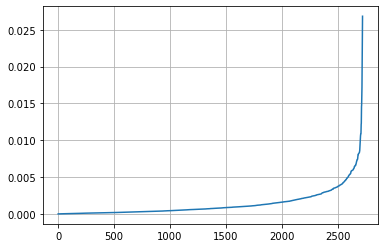

In [20]:
# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid()

Now, we zoom the elbow area. The ideal value for epsilon will be equal to the point of maximum curvature, for this **`epsilon = 0.005`**.

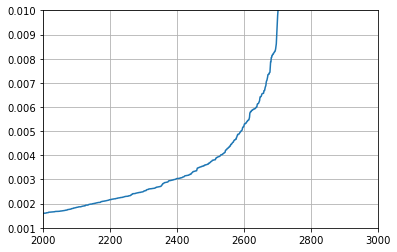

In [21]:
# This zooms the elbow area 
plt.plot(distances)
plt.grid()
plt.xlim([2000, 3000])
plt.ylim([0.001, 0.01])
plt.show()

<a id='dbscan1'></a>
#### **4.5 First run of DBSCAN algorithm**
Here we estimate the epsilon hyperparameter using k nearest neighbors. First, we calculate the average distance between each point in the data set and its 5 nearest neighbors.

In [22]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)

# Adds dimensions to compute clusters
cluster_dataset = venues_cluster[['lat','lng']]
cluster_dataset = np.nan_to_num(cluster_dataset)
cluster_dataset = StandardScaler().fit_transform(cluster_dataset)

# Compute DBSCAN with eps=0.005 and min_samples=5
db = DBSCAN(eps=0.005, min_samples=5).fit(cluster_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Get labels
labels = db.labels_

# Add cluster column to the venues_cluster dataframe
venues_cluster["cluster"] = labels
# Show the clusters and number of points (venues)
venues_cluster.groupby("cluster")["venue_name"].count().to_frame()

venue_name
cluster            
-1             2359
 0                5
 1               15
 2               10
 3               21
 4               14
 5                5
 6               11
 7                6
 8                7
 9                4
 10               7
 11               5
 12              30
 13              12
 14               8
 15               5
 16              10
 17               5
 18               6
 19               6
 20              24
 21               8
 22               5
 23               9
 24              12
 25              34
 26               6
 27              11
 28              25
 29               5
 30               9
 31               5
 32               9
 33               5
 34              24
 35              22
 36               6
 37               8
 38               5
 39              21
 40               7
 41               5
 42               6
 43               5
 44               6

**Number of clusters with vaccination centers:** We get only two clusters with vaccination centers within it (clusters 25 and 26)

In [23]:
venues_cluster[(venues_cluster.category=="Vaccination Center") & (venues_cluster.cluster != -1)]["cluster"].unique()

array([25, 26], dtype=int64)

In [24]:
clusters_with_vaxcenter = venues_cluster[(venues_cluster.category=="Vaccination Center") & (venues_cluster.cluster != -1)]["cluster"].unique().tolist()
clusters_with_vaxcenter.append(-1) # Adds cluster -1 (noise) to the list
clusters_with_vaxcenter

[25, 26, -1]

**Number of clusters without vaccination centers:** Here we get that 43 clusters don't have any vaccination center.

In [25]:
venues_cluster[(venues_cluster.category!="Vaccination Center") & (~venues_cluster.cluster.isin(clusters_with_vaxcenter))]["cluster"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  9,  7,  8, 10, 11, 12, 13, 14, 15, 16,
       22, 17, 18, 19, 38, 20, 21, 23, 24, 27, 28, 41, 29, 30, 43, 31, 32,
       33, 34, 40, 35, 36, 37, 39, 42, 44], dtype=int64)

In [26]:
clusters_without_vaxcenter = venues_cluster[(venues_cluster.category!="Vaccination Center") & 
                                            (~venues_cluster.cluster.isin(clusters_with_vaxcenter))]["cluster"].unique().tolist()
clusters_without_vaxcenter.sort()
len(clusters_without_vaxcenter)

43

**Vaccination centers that belong to clusters:** As we saw before, only one vaccination center.

In [27]:
vaxcenters_in_clusters = venues_cluster[(venues_cluster.category=="Vaccination Center") & 
                                        (venues_cluster.cluster.isin(clusters_with_vaxcenter)) & (venues_cluster.cluster != -1)]
vaxcenters_in_clusters

venue_name            category        lat        lng  \
2726               Plaza Norte  Vaccination Center -12.007614 -77.058953   
2831  Parque Nº 1 Las Palmeras  Vaccination Center -11.988582 -77.072232   

     origin_district  cluster  
2726   INDEPENDENCIA       25  
2831      LOS OLIVOS       26

<a id='problem'></a>
#### **4.6 A problem with first DBSCAN run**
Some vaccination centers are close to clusters but not part of them. In the following example, there is a cluster near a vaccination center, but this vaccination center is not part of the cluster. To fix this, we will increase the epsilon value from 0.005 to 0.05.
- Venues: Small blue circles
- Vaccination centers: Large yellow circles

In [28]:
# Plot a map starting in Lima center
map_lima = folium.Map(location = [-12.3893907,-76.7786623], zoom_start = 17)

df = venues_cluster[venues_cluster.cluster.isin(clusters_without_vaxcenter)]

# Draw small blue circles for venues
for lat,lon,cluster in zip(df['lat'],df['lng'],df['cluster']):
    # if cluster is not noise
    if (cluster != -1):
        folium.CircleMarker([lat,lon], radius=5, color='blue', fill=True, weight=0.3, 
                            fill_color='blue', fill_opacity=0.7, parse_html = False).add_to(map_lima)

# Draw large yellow circles for vaccination centers with labels
for lat,lon,name,district in zip(centers['latitude'],centers['longitude'],centers['vaccination_center'],centers['district']):
    label = '{}, {}'.format(name,district.title())
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius=7, popup=label, color='black', fill=True, weight=0.8,
                        fill_color='yellow', fill_opacity=0.9, parse_html = False).add_to(map_lima)

map_lima

<img src="img maps/map 4.6.png" />

<a id='dbscan2'></a>
#### **4.7 Second run of DBSCAN algorithm**
Here we change the epsilon hyperparameter, now **`epsilon = 0.05`**.

In [29]:
sklearn.utils.check_random_state(1000)

# Adds dimensions to compute clusters
cluster_dataset = venues_cluster[['lat','lng']]
cluster_dataset = np.nan_to_num(cluster_dataset)
cluster_dataset = StandardScaler().fit_transform(cluster_dataset)

# Compute DBSCAN with eps=0.05 and min_samples=5
db = DBSCAN(eps=0.05, min_samples=5).fit(cluster_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Get labels
labels = db.labels_

# Add cluster column to the venues_cluster dataframe
venues_cluster["cluster"] = labels
# Show the clusters and number of points (venues)
venues_cluster.groupby("cluster")["venue_name"].count().to_frame()

venue_name
cluster            
-1              230
 0               87
 1             1436
 2               17
 3               26
 4              192
 5                5
 6               10
 7               18
 8               15
 9                8
 10              10
 11               7
 12              12
 13              23
 14              10
 15              17
 16              16
 17              32
 18               8
 19              11
 20              10
 21             204
 22              11
 23              10
 24               6
 25               6
 26              14
 27               7
 28              10
 29               8
 30              56
 31               5
 32              12
 33              44
 34              18
 35              11
 36               9
 37              19
 38               5
 39              10
 40              10
 41               7
 42              12
 43               7
 44               8
 45              58
 46              11
 47              10
 48               5
 49              10
 50              12
 51               7
 52               6
 53               5

**Number of clusters with vaccination centers:** We now get 22 clusters with vaccination centers within it.

In [30]:
venues_cluster[(venues_cluster.category=="Vaccination Center") & (venues_cluster.cluster != -1)]["cluster"].unique()

array([21,  4,  1, 34, 50, 22, 16, 28, 45, 33, 25, 36, 29,  8, 49, 13,  6,
       14,  0, 30, 32,  5], dtype=int64)

In [31]:
clusters_with_vaxcenter = venues_cluster[(venues_cluster.category=="Vaccination Center") & (venues_cluster.cluster != -1)]["cluster"].unique().tolist()
clusters_with_vaxcenter.append(-1) # Adds cluster -1 (noise) to the list
clusters_with_vaxcenter

[21,
 4,
 1,
 34,
 50,
 22,
 16,
 28,
 45,
 33,
 25,
 36,
 29,
 8,
 49,
 13,
 6,
 14,
 0,
 30,
 32,
 5,
 -1]

**Number of clusters without vaccination centers:** Here we get that 32 clusters don't have any vaccination center.

In [32]:
venues_cluster[(venues_cluster.category!="Vaccination Center") & (~venues_cluster.cluster.isin(clusters_with_vaxcenter))]["cluster"].unique()

array([ 2,  3,  7,  9, 10, 11, 12, 15, 17, 18, 19, 20, 26, 23, 24, 27, 31,
       35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 51, 52, 53],
      dtype=int64)

In [33]:
clusters_without_vaxcenter = venues_cluster[(venues_cluster.category!="Vaccination Center") & 
                                            (~venues_cluster.cluster.isin(clusters_with_vaxcenter))]["cluster"].unique().tolist()
clusters_without_vaxcenter.sort()
len(clusters_without_vaxcenter)

32

**Vaccination centers that belong to clusters:** 74 vaccination centers are installed within 22 clusters.

In [34]:
vaxcenters_in_clusters = venues_cluster[(venues_cluster.category=="Vaccination Center") & 
                                        (venues_cluster.cluster.isin(clusters_with_vaxcenter)) & (venues_cluster.cluster != -1)]
vaxcenters_in_clusters.reset_index(drop=True, inplace=True)
vaxcenters_in_clusters

venue_name            category  \
0               Vacunatorio San Isidro labrador  Vaccination Center   
1                       Clínica Jesus Del Norte  Vaccination Center   
2                                   Plaza Norte  Vaccination Center   
3            Coliseo de la Amistad Perú - Japón  Vaccination Center   
4                  Centro De Vacunación Aljovin  Vaccination Center   
..                                          ...                 ...   
69                             HOSPITAL MILITAR  Vaccination Center   
70                       Hospital Larco Herrera  Vaccination Center   
71                      Estadio Campolo Alcalde  Vaccination Center   
72  Explanada de la Municipalidad de Los Olivos  Vaccination Center   
73                     Parque Nº 1 Las Palmeras  Vaccination Center   

          lat        lng    origin_district  cluster  
0  -12.043744 -76.946264        SANTA ANITA       21  
1  -11.989580 -77.058795      INDEPENDENCIA        4  
2  -12.007614 -77.058953      INDEPENDENCIA        4  
3  -11.978520 -77.050480      INDEPENDENCIA        4  
4  -12.057287 -77.032330               LIMA        1  
..        ...        ...                ...      ...  
69 -12.087420 -77.062723  MAGDALENA DEL MAR        1  
70 -12.098196 -77.065646  MAGDALENA DEL MAR        1  
71 -12.065040 -77.107876           LA PERLA        1  
72 -11.991584 -77.071019         LOS OLIVOS        4  
73 -11.988582 -77.072232         LOS OLIVOS        4  

[74 rows x 6 columns]

---
<a id='results'></a>
### **5. Results**
We have two results to analyze:
- [5.1 Clusters with vaccination centers](#result1)
- [5.2 Clusters without vaccination centers](#result2)

<a id='result1'></a>
#### **5.1 Clusters with vaccination centers**
Here we plot:
- Clusters (22) with vaccination centers within (colorful circles)
- Vaccination centers (74) belonging to those clusters (yellow circles with black border)

As we can see, **the problem we had in section [4.6](#problem) is not present now**.

In [35]:
import matplotlib.cm as cm
import matplotlib.colors as colors

all_clusters = venues_cluster["cluster"].unique().tolist()
all_clusters.sort()

# Setting color scheme for the clusters
x = np.arange(len(all_clusters))
ys = [i + x + (i*x)**2 for i in range(len(all_clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [36]:
# Plot a map starting in Lima center
map_lima = folium.Map(location = [-12.0453,-77.0308], zoom_start = 11)
df = venues_cluster[venues_cluster.cluster.isin(clusters_with_vaxcenter)]

# Draw small blue circles for venues
for lat,lon,cluster in zip(df['lat'],df['lng'],df['cluster']):
    if (cluster != -1):
        folium.CircleMarker([lat,lon], radius=5, color='black', fill=True, weight=0.3, 
                            fill_color=rainbow[cluster], fill_opacity=0.7, parse_html = False).add_to(map_lima)

# Draw large yellow circles for vaccination centers with labels
for lat,lon,name,district in zip(vaxcenters_in_clusters['lat'],vaxcenters_in_clusters['lng'],vaxcenters_in_clusters['venue_name'],vaxcenters_in_clusters['origin_district']):
    label = '{}, {}'.format(name,district.title())
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius=5, popup=label, color='black', fill=True, weight=0.8,
                        fill_color='yellow', fill_opacity=0.9, parse_html = False).add_to(map_lima)

map_lima


<img src="img maps/map 5.1.png" />

<a id='taking_look'></a>
#### **5.2 Clusters without vaccination centers**
Here we plot the clusters without any vaccination center. **These clusters need vaccination centers to be installed**.

In [37]:
# Plot a map starting in Lima center
map_lima = folium.Map(location = [-12.13,-77.0308], zoom_start = 11)
df = venues_cluster[venues_cluster.cluster.isin(clusters_without_vaxcenter)]

# Draw colorful circles for each cluster
for lat,lon,cluster in zip(df['lat'],df['lng'],df['cluster']):
    folium.CircleMarker([lat,lon], radius=5, color='black', fill=True, weight=0.8,
                        fill_color=rainbow[cluster], fill_opacity=0.7, parse_html = False).add_to(map_lima)

map_lima

<img src="img maps/map 5.2.png" />

---
<a id='discussion'></a>
### **6. Discussion**
As a result of the DBSCAN run, we have the following data:
- There are 54 clusters of high population density in Lima and Callao.
- 74 vaccination centers out of 110 belong to 19 clusters of high population density.
- 36 vaccination centers are spread in the noise zone.
- 32 clusters don't have or are far from any vaccination center.

To reach the conclusions, here are some information that may help:
- [Table of clusters and suggested coordinates to install vaccination centers](#info1): It has the clusters and coordinates calculated with average latitude/longitude from points in the clusters. This could be useful to query Foursquare or another source to find near venues where to install the new vaccination centers.
- [Vaccination centers needed](#info2): Map with referential coordinates for the new vaccination centers. This could help to find a middle point to install shared vaccination centers (inter clusters) in case the logistic cost exceeds budget.
- [Table of vaccination centers by district](#info3): Could help to estimate costs based in the number of vaccination centers to install by district.

<a id='info1'></a>
**Table of clusters and suggested coordinates to install vaccination centers:** The following table has:
- Clusters
- District to which the cluster belongs
- Referential latitude: Average latitude from points in the clusters
- Referential longitude: Average longitude from points in the clusters
- Number of venues within the cluster

In [38]:
vaxcenters_needed = pd.DataFrame(columns = ["cluster","district","ref_lat","ref_lng","venues"])

for i in clusters_without_vaxcenter:
    list_cluster = [[i, 
                    df[df.cluster==i]["origin_district"].value_counts().idxmax(),
                    df[df.cluster==i]["lat"].mean(),
                    df[df.cluster==i]["lng"].mean(),
                    df[df.cluster==i]["venue_name"].count()]]
    vaxcenters_needed = vaxcenters_needed.append(pd.DataFrame(list_cluster, columns=["cluster","district","ref_lat","ref_lng","venues"]), ignore_index=True)

vaxcenters_needed["cluster"] = vaxcenters_needed.index.to_list()
vaxcenters_needed["cluster"] = vaxcenters_needed["cluster"] + 1

vaxcenters_needed

cluster                    district    ref_lat    ref_lng venues
0         1                  BELLAVISTA -12.047422 -77.111977     17
1         2  CARMEN DE LA LEGUA REYNOSO -12.020992 -77.105494     26
2         3                 EL AGUSTINO -12.066292 -77.014773     18
3         4                         ATE -12.043131 -76.933174      8
4         5                         ATE -12.023028 -76.922556     10
5         6                         ATE -12.014940 -76.944074      7
6         7                  CARABAYLLO -11.900432 -77.039199     12
7         8                       COMAS -11.940270 -77.071323     17
8         9                 EL AGUSTINO -12.030044 -77.007799     32
9        10                   LA MOLINA -12.078778 -76.918640      8
10       11                   LA MOLINA -12.085069 -76.896899     11
11       12                   LA MOLINA -12.082512 -76.929903     10
12       13                       LURIN -12.275285 -76.870384     10
13       14                       LURIN -12.285656 -76.876173      6
14       15                       LURIN -12.253413 -76.891913     14
15       16                  PACHACAMAC -12.210810 -76.862853      7
16       17               PUNTA HERMOSA -12.352125 -76.813290      5
17       18      SAN JUAN DE LURIGANCHO -12.016550 -76.985180     11
18       19           VILLA EL SALVADOR -12.202330 -76.939918     19
19       20           VILLA EL SALVADOR -12.220434 -76.929596      5
20       21                         ATE -12.035214 -76.882367     10
21       22                         ATE -12.016283 -76.885371     10
22       23                  CARABAYLLO -11.916020 -77.057913      7
23       24                  CHACLACAYO -11.956716 -76.731164     12
24       25                  CHORRILLOS -12.216027 -77.004545      7
25       26                 CIENEGUILLA -12.098917 -76.785255      8
26       27                       LURIN -12.259440 -76.909243     11
27       28                       LURIN -12.239058 -76.866735     10
28       29                       LURIN -12.307674 -76.840946      5
29       30           VILLA EL SALVADOR -12.251240 -76.927203      7
30       31           VILLA EL SALVADOR -12.231239 -76.910651      6
31       32           VILLA EL SALVADOR -12.194641 -76.968378      5

<a id='info2'></a>
**Vaccination centers needed:** This map presents the vaccination centers needed to install. The clusters around this points in the map are far from another vaccination centers.

In [39]:
# Setting color scheme for the clusters
x = np.arange(len(vaxcenters_needed))
ys = [i + x + (i*x)**3 for i in range(len(vaxcenters_needed))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Plot a map starting in Lima center
map_lima = folium.Map(location = [-12.13,-77.0308], zoom_start = 11)

# Draw colorful circles for each vaccination center needed
for lat,lon,cluster,district in zip(vaxcenters_needed['ref_lat'],vaxcenters_needed['ref_lng'],vaxcenters_needed['cluster'], vaxcenters_needed['district']):
    label = 'Cluster {}, {}'.format(cluster, district.title())
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lon], radius=12, popup=label, color='black', fill=True, weight=0.8,
                        fill_color=rainbow[cluster-1], fill_opacity=0.7, parse_html = False).add_to(map_lima)

map_lima

<img src="img maps/map 6.png" />

<a id='info3'></a>
**Table of vaccination centers by district:** This table shows the number of vaccination centers each district should install to cover all the clusters of high population density.

In [40]:
vaxcenters_district = vaxcenters_needed["district"].value_counts().to_frame()
vaxcenters_district.rename(columns={'district': 'vaccination centers needed'}, inplace=True)
vaxcenters_district.index.name = 'district'
vaxcenters_district

vaccination centers needed
district                                              
LURIN                                                6
VILLA EL SALVADOR                                    5
ATE                                                  5
LA MOLINA                                            3
EL AGUSTINO                                          2
CARABAYLLO                                           2
CHACLACAYO                                           1
CIENEGUILLA                                          1
CARMEN DE LA LEGUA REYNOSO                           1
SAN JUAN DE LURIGANCHO                               1
BELLAVISTA                                           1
CHORRILLOS                                           1
PUNTA HERMOSA                                        1
PACHACAMAC                                           1
COMAS                                                1

---
<a id='conclusion'></a>
### **7. Conclusion**
Thirty two vaccination centers should be installed in Lima and Callao to reach to all high population density clusters and, in this way, improve the national vaccination strategy. This could be beneficial if there's a need to address vaccination on demand, without appointments. The fifteen districts in focus to implement the new vaccination centers need to plan the installations and get the appropriate budget to do so, mainly Lurín, Villa El Salvador and Ate, these districts needs more than five new vaccination centers.

In near future, this approach to get the number and location of the vaccination centers should have a change based on the number of vaccinated people. A weighing process to apply to the venues before compute with DBSCAN may be considered.



---